In [4]:
import pandas as pd 
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import os


os.chdir('../Dataset')
path = os.getcwd()


columns = ['class','l_shoulder','r_shoulder','l_arm','r_arm','l_hip','r_hip','l_knee','r_knee']

y82_test = pd.read_csv(os.path.join(path,'y82_testing.csv'), header=None)
y82_train = pd.read_csv(os.path.join(path,'y82_training.csv'), header=None)
L_test = pd.read_csv(os.path.join(path,'L_testing.csv'), header=None)
L_train = pd.read_csv(os.path.join(path,'L_training.csv'), header=None)

combined_test = pd.concat([L_test, y82_test])
combined_train = pd.concat([L_train, y82_train])

combined_test.columns = columns 
combined_train.columns = columns 

combined_test['class'], classes = pd.factorize(combined_test['class'])
combined_train['class'], _ = pd.factorize(combined_train['class'])

classes = list(classes)

In [5]:
all_combined_df = pd.concat([y82_train, y82_test, L_test, L_train])
all_combined = pd.concat([combined_test, combined_train])

def split_features_labels(df):
    return df.drop('class', axis=1), df['class']

# Random Forest Classifer
# 88-89% Maybe 90?

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 3/5] END ......max_depth=1, n_estimators=64;, score=0.552 total time=   0.2s
[CV 2/5] END ......max_depth=1, n_estimators=64;, score=0.636 total time=   0.2s
[CV 1/5] END ......max_depth=1, n_estimators=64;, score=0.656 total time=   0.2s
[CV 4/5] END ......max_depth=1, n_estimators=64;, score=0.571 total time=   0.2s
[CV 5/5] END ......max_depth=1, n_estimators=64;, score=0.596 total time=   0.2s
[CV 2/5] END ......max_depth=4, n_estimators=45;, score=0.864 total time=   0.2s
[CV 1/5] END ......max_depth=4, n_estimators=45;, score=0.814 total time=   0.3s
[CV 3/5] END ......max_depth=4, n_estimators=45;, score=0.866 total time=   0.3s
[CV 4/5] END ......max_depth=4, n_estimators=45;, score=0.838 total time=   0.2s
[CV 5/5] END ......max_depth=4, n_estimators=45;, score=0.822 total time=   0.3s
[CV 1/5] END ......max_depth=2, n_estimators=71;, score=0.683 total time=   0.3s
[CV 2/5] END ......max_depth=1, n_estimators=30;

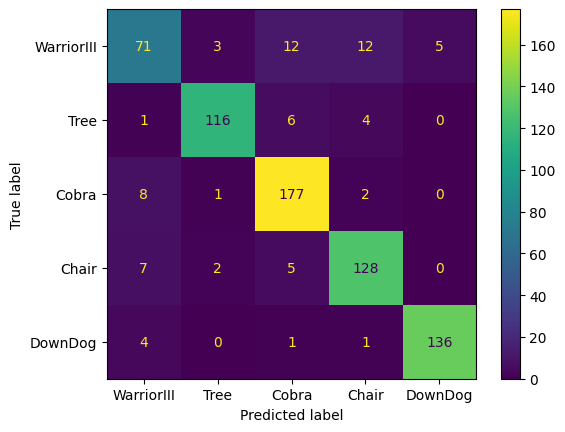

In [44]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
# from sklearn.model_selection import train_test_split // Don't need anymore

RANDOM_ORDER_DATA = True 
MAX_ESTIMATORS = 100
MAX_DEPTH = 8 

if RANDOM_ORDER_DATA:
  mutated_train = combined_train.sample(frac=1)
else:
  mutated_train = combined_train

X_train, y_train = split_features_labels(mutated_train)
X_test, y_test = split_features_labels(combined_test)


forest_classifier = RandomForestClassifier()
param_grid = {'n_estimators' : np.arange(1, MAX_ESTIMATORS),
              'max_depth' : np.arange(1, MAX_DEPTH),
            }

forest_classifier_gscv = RandomizedSearchCV(forest_classifier, param_distributions=param_grid, cv=5, n_jobs=-1, verbose=3)

#fit model to data
forest_classifier_gscv.fit(X_train, y_train)

MAX_DEPTH = forest_classifier_gscv.best_params_['max_depth']
N_ESTIMATORS = forest_classifier_gscv.best_params_['n_estimators']

best_forest = RandomForestClassifier(max_depth=MAX_DEPTH, n_estimators=N_ESTIMATORS)
best_forest.fit(X_train, y_train)

pred = best_forest.predict(X_test)
cm = confusion_matrix(y_test, pred)
display_confusion_matrix = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
display_confusion_matrix.plot()
print(classification_report(y_test, pred))

# KNN Classifer 
# Eh Around 88%


Fitting 5 folds for each of 123 candidates, totalling 615 fits
[CV 1/5] END ..algorithm=kd_tree, n_neighbors=1;, score=0.900 total time=   0.0s
[CV 2/5] END ..algorithm=kd_tree, n_neighbors=1;, score=0.900 total time=   0.0s
[CV 3/5] END ..algorithm=kd_tree, n_neighbors=1;, score=0.891 total time=   0.0s
[CV 4/5] END ..algorithm=kd_tree, n_neighbors=1;, score=0.922 total time=   0.0s
[CV 5/5] END ..algorithm=kd_tree, n_neighbors=1;, score=0.894 total time=   0.0s
[CV 1/5] END ..algorithm=kd_tree, n_neighbors=2;, score=0.908 total time=   0.0s
[CV 2/5] END ..algorithm=kd_tree, n_neighbors=2;, score=0.903 total time=   0.0s
[CV 3/5] END ..algorithm=kd_tree, n_neighbors=2;, score=0.891 total time=   0.0s
[CV 4/5] END ..algorithm=kd_tree, n_neighbors=2;, score=0.922 total time=   0.0s
[CV 5/5] END ..algorithm=kd_tree, n_neighbors=2;, score=0.897 total time=   0.0s
[CV 1/5] END ..algorithm=kd_tree, n_neighbors=3;, score=0.900 total time=   0.0s
[CV 2/5] END ..algorithm=kd_tree, n_neighbors=

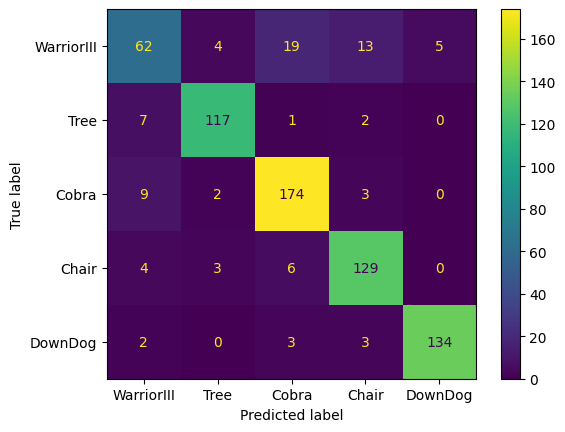

In [40]:
# Grid searching best hyper params 
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier as KNN 

''' Don't need to do this anymore, cause the dataset is already split (Didn't realise this) '''
# from sklearn.model_selection import train_test_split
# 80/20 Split of data, Doesn't randomize, Randomsplit ensures the proportion of classes is the same. 
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
RANDOM_ORDER_DATA = True 



'''Shuffle data for better resuliting'''
if RANDOM_ORDER_DATA:
    mutated_train = combined_train.sample(frac=1)
else:
    mutated_train = combined_train

X_train, y_train = split_features_labels(mutated_train)
X_test, y_test = split_features_labels(combined_test)

max_neighbours = int(np.sqrt(len(X_train)))
knn_algorithms = ['kd_tree', 'brute', 'ball_tree']


knn = KNN()

param_grid = {'n_neighbors' : np.arange(1, max_neighbours),
              'algorithm' : knn_algorithms}

# Using grid search cross validation to find the best value of K 
knn_gscv = GridSearchCV(knn, param_grid, cv=5, verbose=3)

knn_gscv.fit(X_train, y_train)

ALGORITHM = knn_gscv.best_params_['algorithm']
N_NEIGHBORS = knn_gscv.best_params_['n_neighbors']

best_KNN = KNN(algorithm=ALGORITHM, n_neighbors=N_NEIGHBORS)
best_KNN.fit(X_train, y_train)

print(f"Fitted KNN Classifer with {ALGORITHM=} and {N_NEIGHBORS=}")


pred = best_KNN.predict(X_test)
cm = confusion_matrix(y_test, pred)
display_confusion_matrix = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
display_confusion_matrix.plot()
print(classification_report(y_test, pred))

# NN Classifier
## About 87-89% Acc - okay


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV

'''Shuffle data for better resuliting'''
RANDOM_ORDER_DATA = True 
if RANDOM_ORDER_DATA:
    mutated_train = combined_train.sample(frac=1)
else:
    mutated_train = combined_train

X_train, y_train = split_features_labels(mutated_train)
X_test, y_test = split_features_labels(combined_test)

# Define the parameter distributions to sample from
param_dist = {
    'hidden_layer_sizes' : [(i, j) for i in range(1, 15) for j in range(1, 15)],
    'solver': ['adam', 'lbfgs'],
    'activation': ['relu', 'logistic'],
    'alpha' : [0.0001, 0.0001, 0.00005]
}

# Initialize MLPClassifier with default values
mlp = MLPClassifier(max_iter=10000)

random_search = RandomizedSearchCV(mlp, param_distributions=param_dist, n_iter=100, cv=5, n_jobs=-1, verbose=3)

# Train the classifier on your data
random_search.fit(X_train, y_train)

# Get the best hyperparameters from the search
best_params = random_search.best_params_
print("Best solver: ", best_params['solver'])
print("Best activation: ", best_params['activation'])
print("Layers: ", best_params['hidden_layer_sizes'] )
print("Alpha: ", best_params['alpha'])

# Use the best hyperparameters to initialize the MLPClassifier
best_mlp = MLPClassifier(solver=best_params['solver'], activation=best_params['activation'], alpha=best_params['alpha'], hidden_layer_sizes=best_params['hidden_layer_sizes'], max_iter=1000)

# Train the MLPClassifier on the training data
best_mlp.fit(X_train, y_train)



              precision    recall  f1-score   support

           0       0.74      0.62      0.68       103
           1       0.89      0.86      0.88       127
           2       0.85      0.94      0.89       188
           3       0.84      0.84      0.84       142
           4       0.97      0.99      0.98       142

    accuracy                           0.87       702
   macro avg       0.86      0.85      0.85       702
weighted avg       0.86      0.87      0.86       702



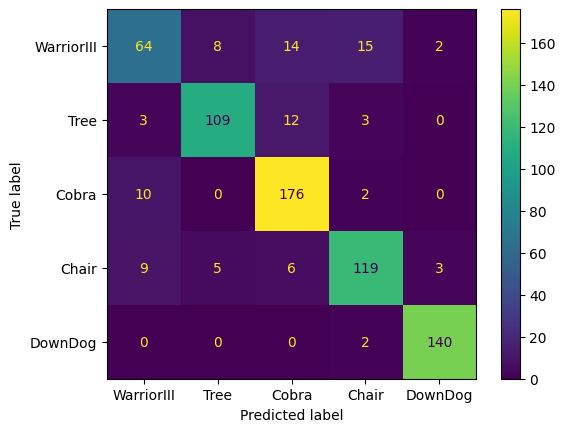

In [35]:
# Use the best hyperparameters to initialize the MLPClassifier
best_mlp = MLPClassifier(solver=best_params['solver'], activation=best_params['activation'], alpha=best_params['alpha'], hidden_layer_sizes=best_params['hidden_layer_sizes'], max_iter=1000)

# Train the MLPClassifier on the training data
best_mlp.fit(X_train, y_train)

pred = best_mlp.predict(X_test)
cm = confusion_matrix(y_test, pred)
display_confusion_matrix = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
display_confusion_matrix.plot()
print(classification_report(y_test, pred))

# SVC Grid Search Classifer
## Consistent 90% Sometimes 91%

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ................C=0.1, gamma=scale;, score=0.842 total time=   0.1s
[CV 2/5] END ................C=0.1, gamma=scale;, score=0.850 total time=   0.1s
[CV 3/5] END ................C=0.1, gamma=scale;, score=0.802 total time=   0.1s
[CV 4/5] END ................C=0.1, gamma=scale;, score=0.844 total time=   0.1s
[CV 5/5] END ................C=0.1, gamma=scale;, score=0.858 total time=   0.1s
[CV 1/5] END ..................C=1, gamma=scale;, score=0.911 total time=   0.1s
[CV 2/5] END ..................C=1, gamma=scale;, score=0.892 total time=   0.1s
[CV 3/5] END ..................C=1, gamma=scale;, score=0.855 total time=   0.1s
[CV 4/5] END ..................C=1, gamma=scale;, score=0.897 total time=   0.1s
[CV 5/5] END ..................C=1, gamma=scale;, score=0.894 total time=   0.1s
[CV 1/5] END ..................C=5, gamma=scale;, score=0.903 total time=   0.1s
[CV 2/5] END ..................C=5, gamma=scale;,

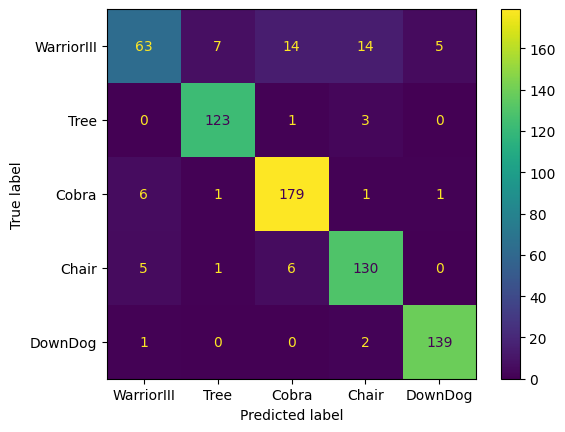

In [48]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.svm import SVC

RANDOM_ORDER_DATA = True 
RANDOM_CV = False

'''Shuffle data for better resuliting'''
if RANDOM_ORDER_DATA:
    mutated_train = combined_train.sample(frac=1)
else:
    mutated_train = combined_train

X_train, y_train = split_features_labels(mutated_train)
X_test, y_test = split_features_labels(combined_test)

svm = SVC(kernel='rbf') 


'''Tried search for gamma manually but it appears using scale is just better''' 
n_features = X_train.shape[1]
gamma_start = 1 / (n_features * max(X_train.var()))
gamma_step = 0.005
gamma_end = gamma_start + (10 * gamma_step)

### Doing Grid Search Now ###

gamma_range = np.arange(gamma_start, gamma_end, gamma_step)
C_range = [0.1, 1, 5, 10]
# set the parameter grid for grid search
param_grid = {
        'C': C_range,
        'gamma' : ['scale']
    }

# perform grid search
if RANDOM_CV:
    grid = RandomizedSearchCV(svm, cv=5, param_distributions=param_grid, verbose=3)
else:
    grid = GridSearchCV(svm, cv=5, param_grid=param_grid, verbose=3)
grid.fit(X_train, y_train)

# best parameters and score
print("Best parameters:", grid.best_params_)
print("Best Score: ", grid.best_score_)

best_svc = SVC(kernel='rbf', C=grid.best_params_['C'], gamma=grid.best_params_['gamma'], probability=True)

best_svc.fit(X_train, y_train)

''' Plotting '''

pred = best_svc.predict(X_test)
cm = confusion_matrix(y_test, pred)
display_confusion_matrix = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
display_confusion_matrix.plot()
print(classification_report(y_test, pred))

# Video & Classifer Integration

In [49]:
import cv2
import mediapipe as mp
import numpy as np
import time 

mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

MIN_DETECTION_CONFIDENCE = 0.5
MIN_TRACKING_CONFIDENCE = 0.5

# All landmark except for hand and face specific
RelevantLandmarks = list(mp_pose.PoseLandmark)[11:17] + list(mp_pose.PoseLandmark)[23:29]

l_hip_landmark_angle_idx = (11,23,25)
r_hip_landmark_angle_idx = (12,24,26)

l_shoulder_landmark_angle_idx = (13,11,23)
r_shoulder_landmark_angle_idx = (14,12,24)

l_arm_landmark_angle_idx = (15,13,11)
r_arm_landmark_angle_idx = (16,14,12)

l_knee_landmark_angle_idx = (23,25,27)
r_knee_landmark_angle_idx = (24,26,28)

#Match idx of RelevantLandmarks 
angle_idxs_required = [
    l_shoulder_landmark_angle_idx,
    r_shoulder_landmark_angle_idx,
    
    l_arm_landmark_angle_idx,
    r_arm_landmark_angle_idx,
    
    l_hip_landmark_angle_idx,
    r_hip_landmark_angle_idx,
    
    l_knee_landmark_angle_idx,
    r_knee_landmark_angle_idx
]
skip_landmark = {
    mp_pose.PoseLandmark.RIGHT_ANKLE,
    mp_pose.PoseLandmark.LEFT_ANKLE,
    mp_pose.PoseLandmark.RIGHT_WRIST,
    mp_pose.PoseLandmark.LEFT_WRIST
}

In [50]:
landmarkStr = {
    mp_pose.PoseLandmark.NOSE : "NOSE",
    mp_pose.PoseLandmark.LEFT_EYE_INNER : "LEFT_EYE_INNER",
    mp_pose.PoseLandmark.LEFT_EYE : "LEFT_EYE",
    mp_pose.PoseLandmark.LEFT_EYE_OUTER : "LEFT_EYE_OUTER",
    mp_pose.PoseLandmark.RIGHT_EYE_INNER : "RIGHT_EYE_INNER",
    mp_pose.PoseLandmark.RIGHT_EYE : "RIGHT_EYE",
    mp_pose.PoseLandmark.RIGHT_EYE_OUTER : "RIGHT_EYE_OUTER",
    mp_pose.PoseLandmark.LEFT_EAR : "LEFT_EAR",
    mp_pose.PoseLandmark.RIGHT_EAR : "RIGHT_EAR",
    mp_pose.PoseLandmark.MOUTH_LEFT : "MOUTH_LEFT",
    mp_pose.PoseLandmark.MOUTH_RIGHT : "MOUTH_RIGHT",
    mp_pose.PoseLandmark.LEFT_SHOULDER : "LEFT_SHOULDER",
    mp_pose.PoseLandmark.RIGHT_SHOULDER : "RIGHT_SHOULDER",
    mp_pose.PoseLandmark.LEFT_ELBOW : "LEFT_ELBOW",
    mp_pose.PoseLandmark.RIGHT_ELBOW : "RIGHT_ELBOW",
    mp_pose.PoseLandmark.LEFT_WRIST : "LEFT_WRIST",
    mp_pose.PoseLandmark.RIGHT_WRIST : "RIGHT_WRIST",
    mp_pose.PoseLandmark.LEFT_PINKY : "LEFT_PINKY",
    mp_pose.PoseLandmark.RIGHT_PINKY : "RIGHT_PINKY",
    mp_pose.PoseLandmark.LEFT_INDEX : "LEFT_INDEX",
    mp_pose.PoseLandmark.RIGHT_INDEX : "RIGHT_INDEX",
    mp_pose.PoseLandmark.LEFT_THUMB : "LEFT_THUMB",
    mp_pose.PoseLandmark.RIGHT_THUMB : "RIGHT_THUMB",
    mp_pose.PoseLandmark.LEFT_HIP : "LEFT_HIP",
    mp_pose.PoseLandmark.RIGHT_HIP : "RIGHT_HIP",
    mp_pose.PoseLandmark.LEFT_KNEE : "LEFT_KNEE",
    mp_pose.PoseLandmark.RIGHT_KNEE : "RIGHT_KNEE",
    mp_pose.PoseLandmark.LEFT_ANKLE : "LEFT_ANKLE",
    mp_pose.PoseLandmark.RIGHT_ANKLE : "RIGHT_ANKLE",
    mp_pose.PoseLandmark.LEFT_HEEL : "LEFT_HEEL",
    mp_pose.PoseLandmark.RIGHT_HEEL : "RIGHT_HEEL",
    mp_pose.PoseLandmark.LEFT_FOOT_INDEX : "LEFT_FOOT_INDEX",
    mp_pose.PoseLandmark.RIGHT_FOOT_INDEX : "RIGHT_FOOT_INDEX"
}

def calc_angle(a, b, c):
    a = np.array(a)
    b = np.array(b)    
    c = np.array(c)   
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    
    if angle > 180.0:
        angle = 380-angle 
    
    return angle 

In [51]:
def classify_pose(example, classifer):
    example = pd.DataFrame(np.array(example).reshape(1, -1), columns=columns[1:])
    

    if classifer == 'KNN':
        probabilty_classes = best_KNN.predict_proba(example)
    elif classifer == 'Forest':
        probabilty_classes = best_forest.predict_proba(example)
    elif classifer == 'SVC':
        probabilty_classes = best_svc.predict_proba(example)
    elif classifer == 'NN':
        probabilty_classes = best_mlp.predict_proba(example)
    else:
        raise Exception("Please enter valid classifer. Currently only ('KNN' | 'Forest' | 'NN' | 'SVC')")

    
    prob_predicted_classes = [] 
    for class_idx, prob in enumerate(probabilty_classes[0]):
        prob_predicted_classes.append((classes[class_idx], prob))
        
    prob_predicted_classes.sort(key = lambda x: x[1], reverse=True)
    
    # Get the highest predicted class 
    predicted_class = prob_predicted_classes[0]
    
    return (predicted_class, sorted(prob_predicted_classes, key = lambda x: x[1], reverse=True))

# Sanity test classification 
classify_pose([8.390697637127042, 13.364568331384618, 16.49759248897499, 153.50000646379374, 173.20291493738577, 199.52935190007366, 179.00845878279233, 198.25172013734928], classifer='SVC')

(('Tree', 0.3884519312068588),
 [('Tree', 0.3884519312068588),
  ('Cobra', 0.24166461512064283),
  ('DownDog', 0.20248227199052757),
  ('WarriorIII', 0.1422980993108466),
  ('Chair', 0.025103082371124446)])

In [55]:
CLASSIFIER = 'Forest'

# Create two windows to display the images
cv2.namedWindow("Real Image", cv2.WINDOW_NORMAL)
cv2.namedWindow("Pose Skeleton", cv2.WINDOW_NORMAL)
last_class = ''

''' Using the media pose model'''
with mp_pose.Pose(min_detection_confidence=MIN_DETECTION_CONFIDENCE, min_tracking_confidence=MIN_TRACKING_CONFIDENCE) as pose:
    '''
        Capturing webcam footage 
    '''
    cap = cv2.VideoCapture(0) # this is the magic!

    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
    while cap.isOpened():
        suc, frame = cap.read() 
        if not suc:
            print("Frame empty..")
            continue 
        
        #Recolor image 
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        
        # Make detections 
        results = pose.process(image=image)
        pose_landmarks = results.pose_landmarks
        try: 

            ''' Converting landmarks into angles'''
            pose_relevant_landmark_angles = []
            # Going through all relevant landmarks, extracting their key angles
            # Calculating the angle then adding to array 
            for i1, i2, i3 in angle_idxs_required:
                
                fst = (pose_landmarks.landmark[i1].x, pose_landmarks.landmark[i1].y)
                snd = (pose_landmarks.landmark[i2].x, pose_landmarks.landmark[i2].y)
                thrd = (pose_landmarks.landmark[i3].x, pose_landmarks.landmark[i3].y)
                
                
                pose_relevant_landmark_angles.append(calc_angle(fst, snd, thrd))
            #Getting cords of the landmarks FOR ANGLES WE CALC'D CORDS FOR
            pose_relevant_landmark_cords = [[pose_landmarks.landmark[idx].x, pose_landmarks.landmark[idx].y]
                                            for _, idx, _ in angle_idxs_required if idx not in skip_landmark]
            
            pose_relevant_landmark_angles_visual = np.around(pose_relevant_landmark_angles, 2).astype(str).tolist()
            
            ''' CLASSIFICATION OF POSE''' 
            predicted_pose, prob_predictions = classify_pose(pose_relevant_landmark_angles, CLASSIFIER)
            
            ''' Pose Threshold'''

            if (predicted_pose[1] >= 0.70):
                if last_class != predicted_pose:
                    last_class = predicted_pose
                    print(predicted_pose)
            else:
                if last_class != 'None':
                    last_class = 'None'
                    print("No Pose Detected")

            ''' First Window '''
            #Revert image color 
            image.flags.writeable = True 
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            #Render detections 
            mp_drawing.draw_landmarks(
                image, 
                results.pose_landmarks, 
                mp_pose.POSE_CONNECTIONS,
                mp_drawing.DrawingSpec(color=(50, 145, 168), circle_radius=2, thickness=2),
                mp_drawing.DrawingSpec(color=(209, 192, 42), circle_radius=2, thickness=2)
            )
            
            cv2.putText(image, 
                            predicted_pose[0],
                            tuple(np.multiply([640//2,480//2], [640, 480]).astype(int)),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA 
                        ) 
            
            ''' Second Window '''
            black_image = np.zeros((frame.shape[0], frame.shape[1], 3), np.uint8)

            # Render detections on the black image
            mp_drawing.draw_landmarks(
                black_image, 
                results.pose_landmarks, 
                mp_pose.POSE_CONNECTIONS,
                mp_drawing.DrawingSpec(color=(50, 145, 168), circle_radius=2, thickness=2),
                mp_drawing.DrawingSpec(color=(209, 192, 42), circle_radius=2, thickness=2)
            )
        
        except Exception as e:
            print(e)
            
        # Display the two images side by side
        result = np.concatenate((image, black_image), axis=1)
        # cv2.imshow("Pose Skeleton", black_image)
        # cv2.imshow("Real Image", image)|
        cv2.imshow("Image & Skele", result)


        # Closing the video capture  
        if cv2.waitKey(1) & 0xFF == ord('w'):
            break
    
    
cap.release() 
cv2.destroyAllWindows()

No Pose Detected
('Tree', 0.7393734071132628)
No Pose Detected
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object

KeyboardInterrupt: 